<a href="https://colab.research.google.com/github/syifaurrohman/capstone-project/blob/main/SDI_Hacktiv_Data_Syifaurrohman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from langchain_community.llms import Replicate

#Ambil granite dari replicate
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct"
)

In [48]:
!pip install pandas
!pip install -U langchain langchain-community langchain-experimental replicate

In [49]:
import pandas as pd

df = pd.read_csv("fake_job_postings.csv")
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [50]:
from langchain_experimental.agents.agent_toolkits.pandas.base import (
    create_pandas_dataframe_agent
)

agent = create_pandas_dataframe_agent(
    llm=llm,
    df=df,
    verbose=True,
    allow_dangerous_code=True,  # opt-in for Python REPL execution
)

In [59]:
df.info()
df.isnull().sum()
df['fraudulent'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

,count
fraudulent,
0,17014
1,866


In [60]:
df = df.drop(columns=['job_id', 'salary_range'])
df = df.dropna(subset=['title', 'description'])


In [61]:
X = df['description']
y = df['fraudulent']


In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [64]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3394
           1       1.00      0.35      0.52       182

    accuracy                           0.97      3576
   macro avg       0.98      0.68      0.75      3576
weighted avg       0.97      0.97      0.96      3576



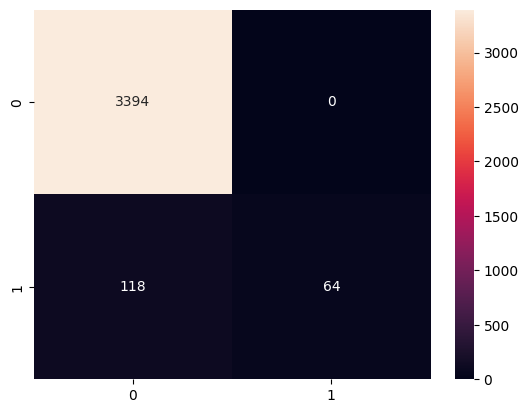

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.show()

In [67]:
agent.invoke({"input": "Summarize the main differences between real and fake job postings in this dataset."})



> Entering new AgentExecutor chain...
Thought: To summarize the main differences between real and fake job postings in this dataset, I need to examine the provided information for distinguishing characteristics. From the given snippets, real job postings appear to include comprehensive details such as job descriptions, required skills, company overviews, benefits, and employment types. Fake job postings, on the other hand, might lack specifics or have generic information. I will analyze the dataset entries for these discrepancies.

Action: python_repl_ast

Action Input:
```python
import pandas as pd

# Assuming df is already defined and loaded with the given data
real_jobs = df[df['fraudulent'] == 0]
fake_jobs = df[df['fraudulent'] == 1]

real_jobs_summary = real_jobs.describe().transpose()
fake_jobs_summary = fake_jobs.describe().transpose()

real_jobs_summary, fake_jobs_summary
```
KeyError: 'fraudulent'Thought: It seems there was an error because the 'fraudulent' column does not e

{'input': 'Summarize the main differences between real and fake job postings in this dataset.',
 'output': "Based on the provided data, the main differences between real and fake job postings in this dataset appear as follows:\n\n1. **Company Information**: Real job postings typically provide more detailed company descriptions, including their mission, vision, and unique selling propositions. Fake job postings often lack this depth and may only mention the company name without elaborating on their operations or culture.\n\n2. **Job Description Specificity**: Real job postings usually include detailed descriptions of the roles, responsibilities, and required skills. Fake job postings often have vague or generic descriptions, possibly omitting specific tasks or necessary qualifications.\n\n3. **Employment Type and Benefits**: Real job postings clearly state the employment type (full-time, part-time, contract, etc.) and often mention benefits like health insurance, retirement plans, or pa

In [68]:
# Buat kolom baru berisi panjang teks
df['desc_length'] = df['description'].astype(str).apply(len)
df['profile_length'] = df['company_profile'].astype(str).apply(len)

# Cek rata-rata panjang deskripsi untuk real vs fake
df.groupby('fraudulent')[['desc_length', 'profile_length']].mean()


,desc_length,profile_length
fraudulent,,
0,1221.219701,641.232456
1,1156.169942,233.190751


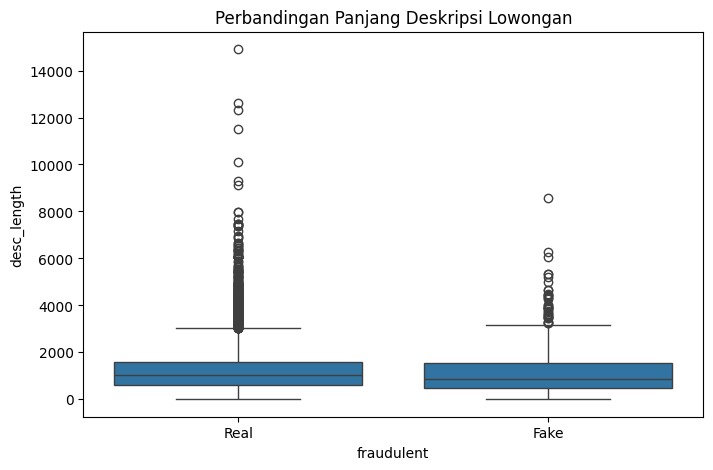

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='fraudulent', y='desc_length', data=df)
plt.xticks([0,1], ['Real', 'Fake'])
plt.title("Perbandingan Panjang Deskripsi Lowongan")
plt.show()


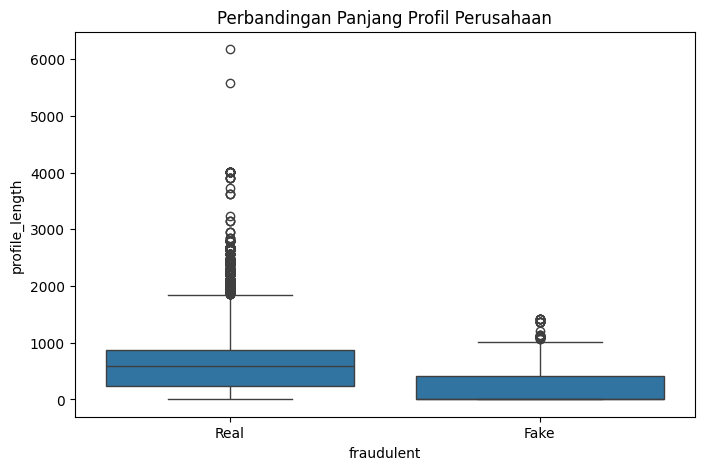

In [70]:
plt.figure(figsize=(8,5))
sns.boxplot(x='fraudulent', y='profile_length', data=df)
plt.xticks([0,1], ['Real', 'Fake'])
plt.title("Perbandingan Panjang Profil Perusahaan")
plt.show()


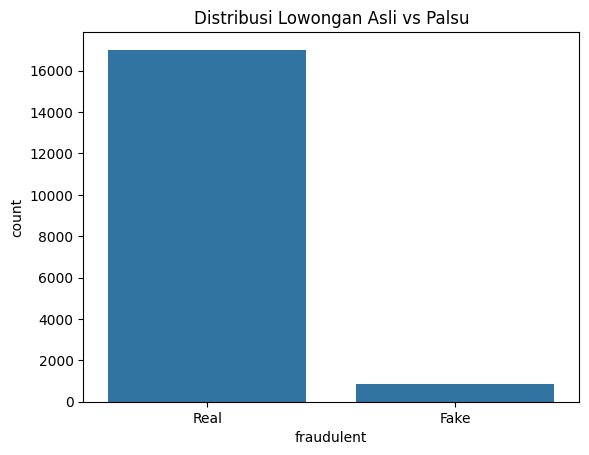

In [71]:
sns.countplot(x='fraudulent', data=df)
plt.xticks([0,1], ['Real', 'Fake'])
plt.title("Distribusi Lowongan Asli vs Palsu")
plt.show()
